
# Quickstart tutorial

To learn to use Dingo, we recommend starting with the examples provided in the `/examples`
folder. The YAML files contained in this directory (and subdirectories) contain
configuration settings for the various Dingo tasks (constructing training data, training networks, and performing inference). These files should be provided as input to the
command-line scripts, which then run Dingo and save output files. These output files
contain as metadata the settings in the `.yaml` files, and they may usually be inspected
by running `dingo_ls`.

```{mermaid}
flowchart TB
    dataset_settings[dataset_settings.yaml]
    dataset_settings-->generate_dataset(["dingo_generate_dataset
    #nbsp; #nbsp; --settings_file dataset_settings.yaml
    #nbsp; #nbsp; --out_file waveform_dataset.hdf5"])
    style generate_dataset text-align:left
    asd_settings[asd_dataset_settings.yaml]
    asd_settings-->generate_asd(["generate_asd_dataset
    #nbsp; #nbsp; --settings_file dataset_settings.yaml
    #nbsp; #nbsp; --data_dir asd_dataset"])
    style generate_asd text-align:left
    train_init(["dingo_train 
    #nbsp; #nbsp; --settings_file train_settings_init.yaml
    #nbsp; #nbsp; --train_dir model_init"])
    style train_init text-align:left
    train_settings_init[train_settings_init.yaml]
    train_settings_init-->train_init
    generate_dataset--->train_init
    generate_asd--->train_init
    generate_dataset--->train_main(["dingo_train 
    #nbsp; #nbsp; --settings_file train_settings_main.yaml
    #nbsp; #nbsp; --train_dir model_main"])
    style train_main text-align:left
    train_settings_main[train_settings_main.yaml]
    generate_asd--->train_main
    train_settings_main-->train_main
    train_init-->inference(["dingo_analyze_event
    #nbsp; #nbsp; --model model_main/model_stage_1.pt
    #nbsp; #nbsp; --model_init model_init/model_stage_1.pt
    #nbsp; #nbsp; --num_samples 50000
    #nbsp; #nbsp; --gps_time_event 1126259462.4"])
    style inference text-align:left
    train_main-->inference
    inference-->samples[dingo_samples-1126259462.4.hdf5]
```




After configuring the settings files, the scripts may be used as follows, assuming the
Dingo `venv` is active.

## Generate training data

### Waveforms

To generate a waveform dataset for training, execute

```
dingo_generate_dataset --settings_file waveform_dataset_settings.yaml --num_processes N --out_file waveform_dataset.hdf5
```

where `N` is the number of processes you would like to use to generate the waveforms in
parallel. This saves the dataset of waveform polarizations in the
file `waveform_dataset.hdf5` (typically compressed using SVD, depending on configuration).

One can use `dingo_generate_dataset_dag` to set up a condor DAG for generating waveforms
on a cluster. This is typically useful for slower waveform models.

### Noise ASDs

Training also requires a dataset of noise ASDs, which are sampled randomly for each
training sample. To generate this dataset based on noise observed during a run, execute

```
dingo_generate_ASD_dataset --data_dir data_dir --settings_file asd_dataset_settings.yaml
```

This will download data from the GWOSC website and create a `/tmp` directory, in which the
estimated PSDs are stored. Subsequently, these are collected together into a final `.hdf5`
ASD dataset.
If no `settings_file` is passed, the script will attempt to use the default
one `data_dir/asd_dataset_settings.yaml`.

## Training

With a waveform dataset and ASD dataset(s), one can train a neural network. Configure
the `train_settings.yaml` file to point to these datasets, and run

```
dingo_train --settings_file train_settings.yaml --train_dir train_dir
```

This will configure the network, train it, and store checkpoints, a record of the history,
and the final network in the directory `train_dir`. Alternatively, to resume training from
a checkpoint file, run

```
dingo_train --checkpoint model.pt --train_dir train_dir
```

If using CUDA on a machine with several GPUs, be sure to first select the desired GPU
number using the `CUDA_VISIBLE_DEVICES` environment variable. If using a cluster, Dingo
can be trained using `dingo_train_condor`.

Example training files can be found under `examples/training`. There are a few .yaml files.
`train_settings_toy.yaml` and `train_settings_production.yaml` train a flow to
estimate the full posterior of the event conditioned on the time of coalescence
in the detectors. The "toy" label is to indicate this should be used for production but 
rather only to get a feel for the Dingo pipeline. The production settings contain tested 
settings. Note that depending on the waveform model and event, these may need to occasionally
be tuned. `train_settings_init_toy.yaml` and `train_settings_init_production.yaml` train
flows to estimate the time of coalescence in the individual detectors. These two
networks are needed to use [**GNPE**](gnpe.md). This is is the preferred and
most tested way of using Dingo. 

Alternatively, the `train_settings_no_gnpe_toy.yaml` and
`train_settings_no_gnpe_production.yaml` contain settings to train a network
without the GNPE step. Note the lack of a `data/gnpe_time_shifts` option. While this is not
recommended for production, it is still pedagogically useful and offers some flexibility.  

## Inference

Once a Dingo model is trained, inference for real events can be performed using
[**dingo_pipe**](dingo_pipe.md). There are 3 main inference steps, downloading the data, 
running Dingo on this data and finally running importance sampling. The basic
idea is to create a .ini file which contains the filepaths of the Dingo networks
trained above and the segment of data to analyze. An example .ini file can be
found under `examples/pipe/GW150914.ini`. 

To do inference, cd into the directory with the .ini file and run 

```
dingo_pipe GW150914.ini
```


One can also separate out these steps with the CLI. First one would generate a proposal
using:

```
dingo_analyze_event
  --model model
  --model_init model_init
  --gps_time_event gps_time_event
  --num_samples num_samples
  --num_gnpe_iterations num_gnpe_iterations
  --batch_size batch_size
```

where model.pt is the path of the trained Dingo mode, gps_time_event is the GPS
time of the event to be analyzed (e.g., 1126259462.4 for GW150914), num_samples
is the number of desired samples and batch_size is the batch size (the larger
the faster the computation, but limited by GPU memory). Dingo downloads the
event data from GWOSC. It also estimates the noise ASD from data prior to the
event.

Then one can do importance sampling by running 

`python dingo/gw/importance_sampling/importance_weights.py --settings is_settings.yaml`

where `is_settings.yaml` contains the settings, and in particular points to the output
file that was previously generated by Dingo.


# Running inference on an injection 



A simple use case could be creating an injection consistent with what the network was trained on, and then running Dingo on it. First one can instantiate the :class:`dingo.gw.injection.Injection` using the metadata from the PosteriorModel (the trained network). An ASD dataset also needs to be specified, one can take the fiducial asd dataset the network was trained on. 

In [ ]:
from dingo.core.models import PosteriorModel
import dingo.gw.injection as injection
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset

main_pm = PosteriorModel(
    device="cuda",
    model_filename="/path/to/main_network", 
    load_training_info=False
)

init_pm = PosteriorModel(
    device='cuda',
    model_filename="/path/to/init_network",
    load_training_info=False
)

injection_generator = injection.Injection.from_posterior_model_metadata(main_pm.metadata)
asd_fname = main_pm.metadata["train_settings"]["training"]["stage_0"]["asd_dataset_path"]
asd_dataset = ASDDataset(file_name=asd_fname)
injection_generator.asd = {k:v[0] for k,v in asd_dataset.asds.items()}

intrinsic_parameters = {
    "chirp_mass": 35,
    "mass_ratio": 0.5,
    "a_1": .3,
    "a_2": .5,
    "tilt_1": 0.,
    "tilt_2": 0.,
    "phi_jl": 0.,
    "phi_12": 0.
}

extrinsic_parameters = {
    'phase': 0.,
    'theta_jn': 2.3,
    'geocent_time': 0.,
    'luminosity_distance': 400.,
    'ra': 0.,
    'dec': 0.,
    'psi': 0.,
}

theta = {**intrinsic_parameters, **extrinsic_parameters}
strain_data = injection_generator.injection(theta)

Then one can create a injections and do inference on them.

GNPE parameters:  ['H1_time', 'L1_time']
GNPE kernel:  {'H1_time': Uniform(minimum=-0.001, maximum=0.001, name=None, latex_label=None, unit=None, boundary=None), 'L1_time': Uniform(minimum=-0.001, maximum=0.001, name=None, latex_label=None, unit=None, boundary=None)}
Running sampler to generate 50000 samples.
it 0.	min pvalue: -inf	proxy mean:  -0.01327 -0.01158 	proxy std: 0.00107 0.00105 	times: 0.008574485778808594 1.0312247276306152 0.006127357482910156
it 1.	min pvalue: 0.000	proxy mean:  -0.01352 -0.01167 	proxy std: 0.00103 0.00103 	times: 0.008184194564819336 1.0291903018951416 0.013202190399169922
it 2.	min pvalue: 0.000	proxy mean:  -0.01364 -0.01178 	proxy std: 0.00099 0.00100 	times: 0.0077817440032958984 1.0502443313598633 0.0037407875061035156
it 3.	min pvalue: 0.000	proxy mean:  -0.01373 -0.01186 	proxy std: 0.00096 0.00097 	times: 0.005512237548828125 1.050232172012329 0.013206958770751953
it 4.	min pvalue: 0.000	proxy mean:  -0.01379 -0.01193 	proxy std: 0.00094 0.0009

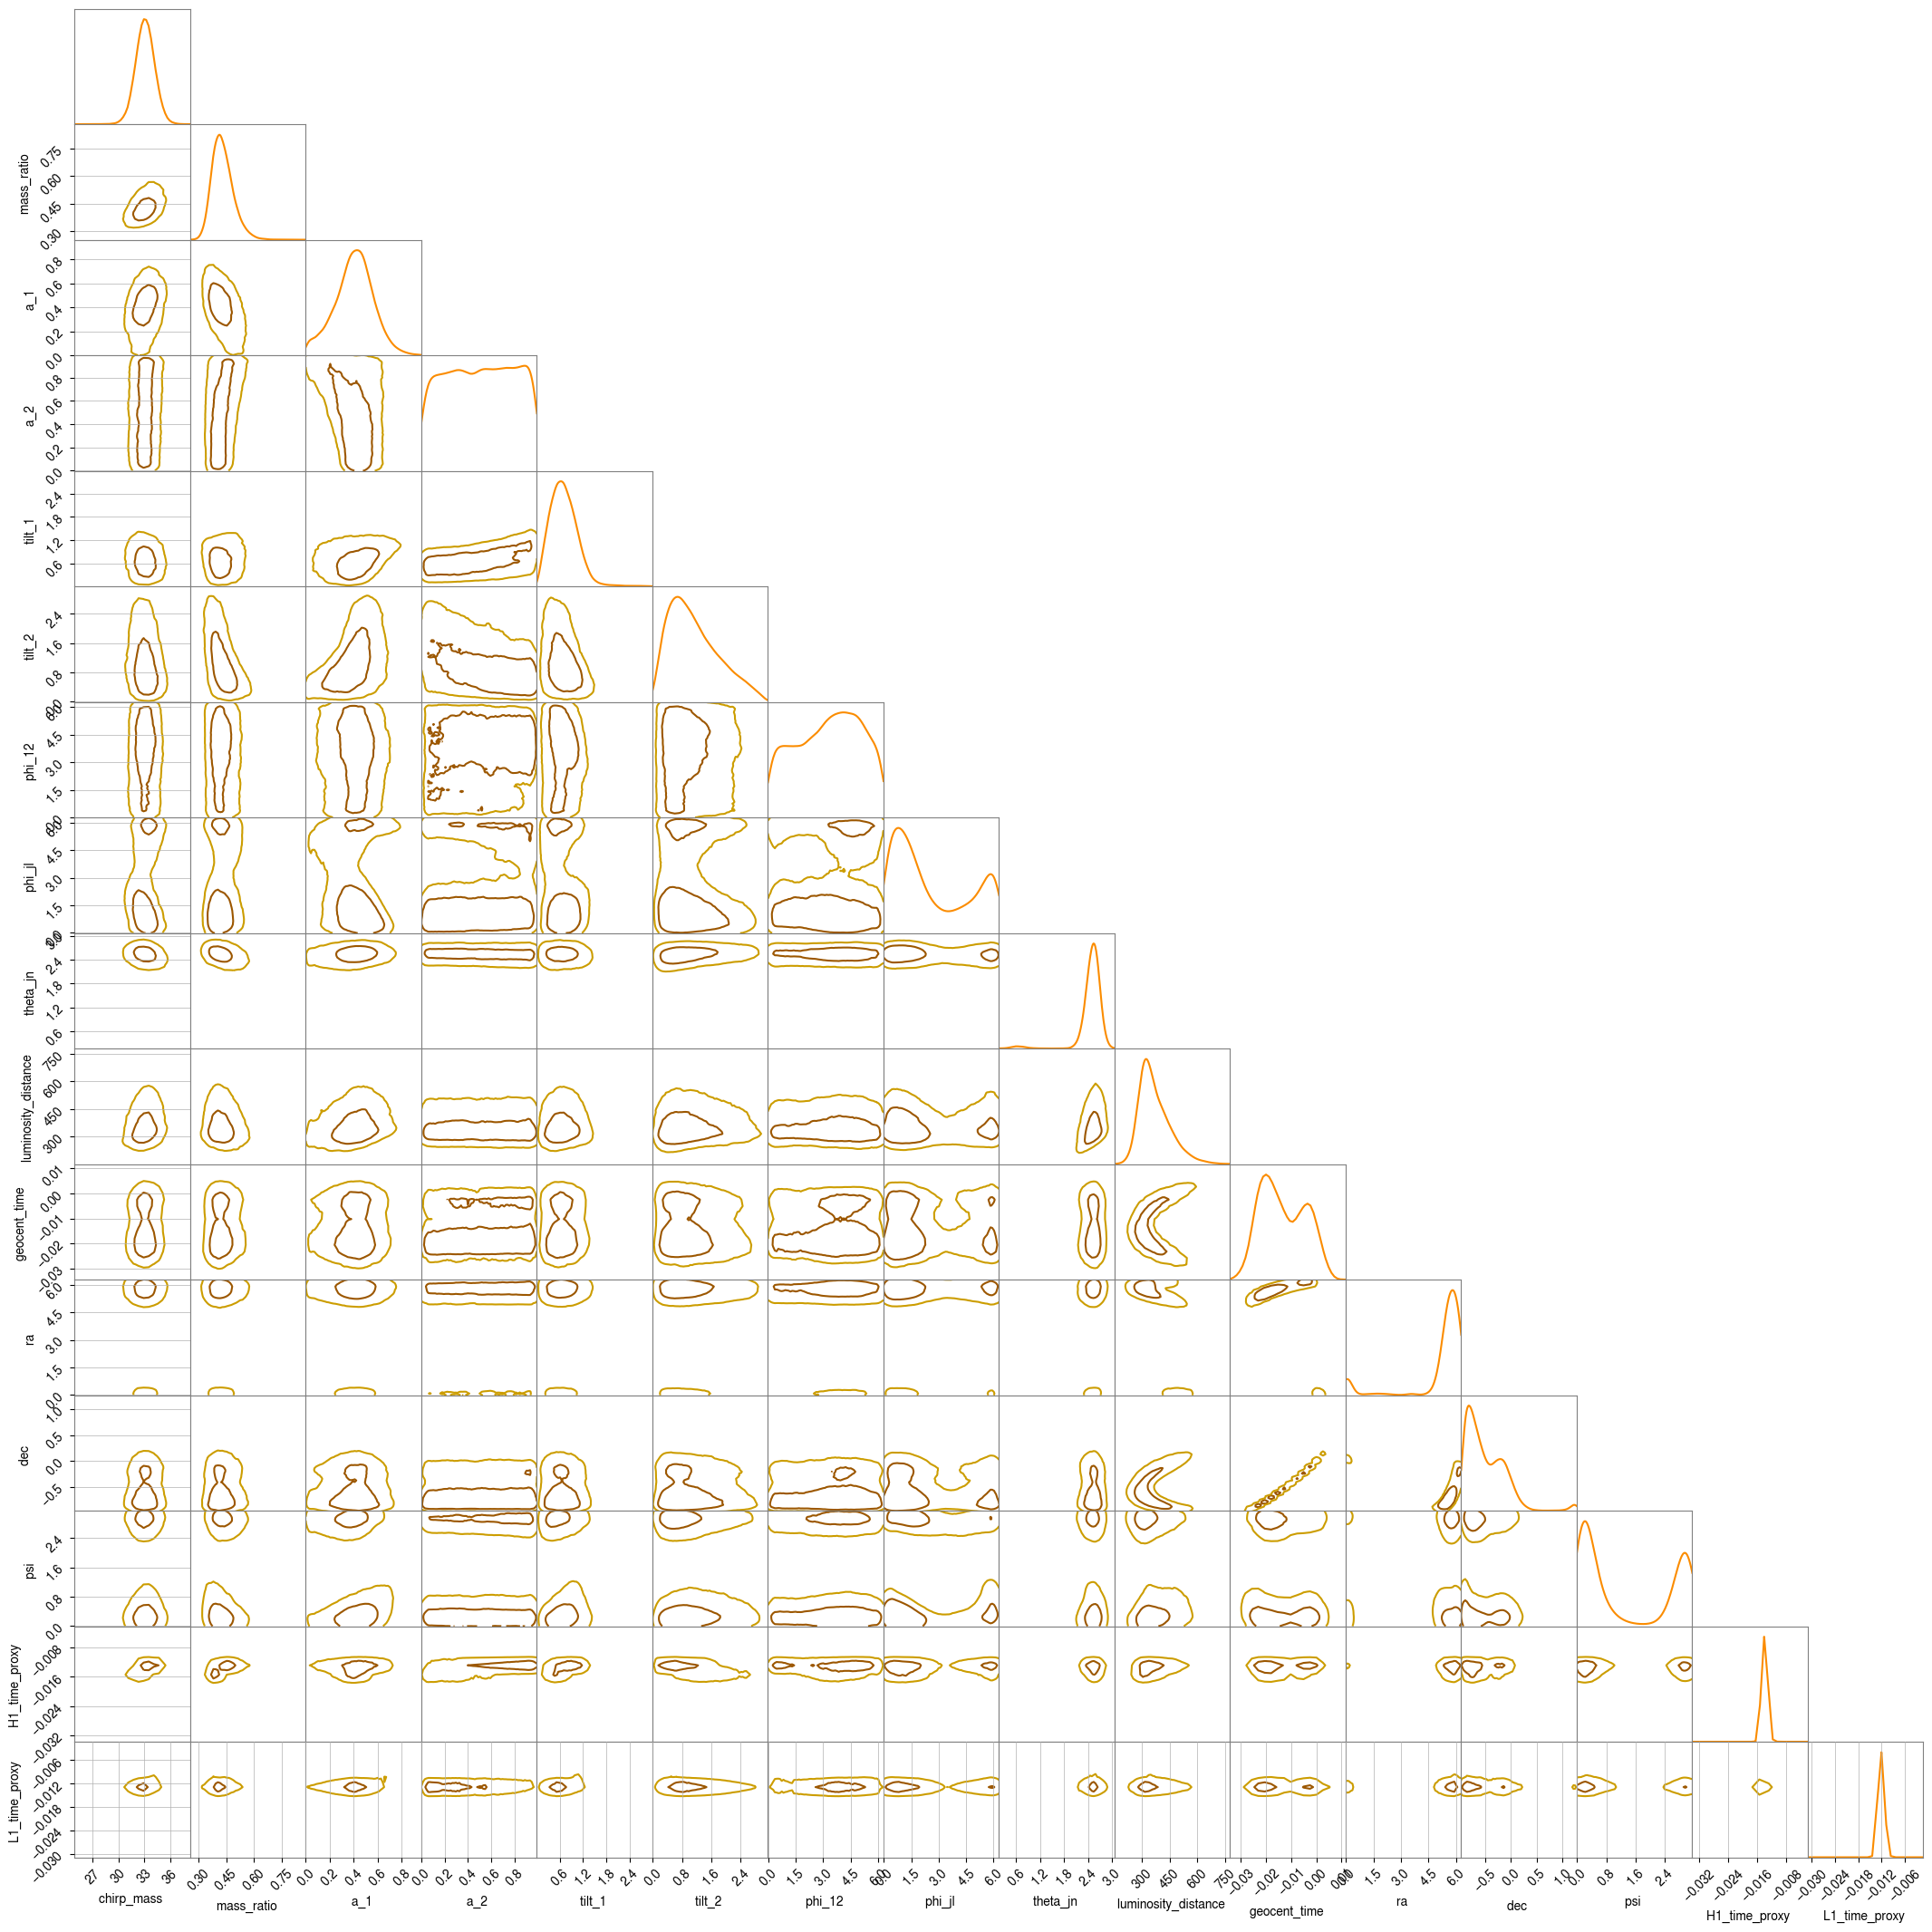

In [29]:
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

init_sampler = GWSampler(model=init_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)
sampler.context = strain_data
sampler.run_sampler(num_samples=50_000, batch_size=10_000)
result = sampler.to_result()
result.plot_corner()